In [1]:
!pip install -q pyjanitor

In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import janitor

In [3]:
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('----------------User uploaded file "{name}"'.format(
      name=fn))
# now you can use the uploaded files
# example:
df = pd.read_csv(fn)


Saving climate_headlines_sentiment.csv to climate_headlines_sentiment (1).csv
----------------User uploaded file "climate_headlines_sentiment (1).csv"


In [5]:
df=df.clean_names()
df.head(1)

,unnamed_0,headline,link,content,sentiment,justification
0,0,Australia's year ahead in climate and environm...,https://www.abc.net.au/news/science/2024-01-23...,The year has barely started and extreme weath...,0.0,The headline is unclear about its direct impac...


In [6]:
df=df[["headline","content","sentiment"]]
df.head(2)

,headline,content,sentiment
0,Australia's year ahead in climate and environm...,The year has barely started and extreme weath...,0.0
1,Projections reveal the vulnerability of freshw...,"“Water from groundwater, rivers and rainfall ...",-0.5


In [7]:
df.shape

(1024, 3)

In [8]:
df.isna().sum()

,0
headline,0
content,0
sentiment,1


In [9]:
df.dropna(subset=["sentiment"],inplace=True)

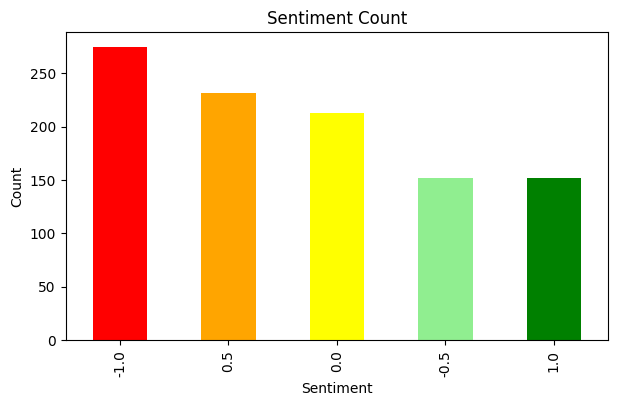

In [ ]:
import matplotlib.pyplot as plt
sentiment_count=df.sentiment.value_counts()

plt.figure(figsize=(7,4))
sentiment_count.plot(kind="bar",color=['red','orange','yellow','lightgreen','green'])
plt.title("Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

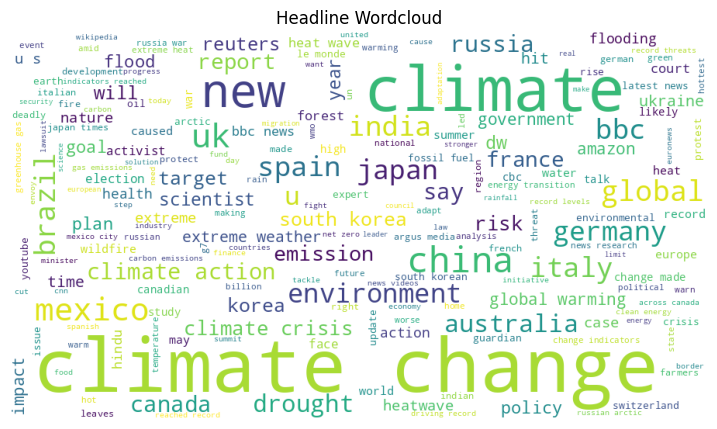

In [ ]:
text=" ".join(df.headline)
wordcloud=WordCloud(width=900,height=500,background_color="white").generate(text.lower())
plt.figure(figsize=(9,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Headline Wordcloud")
plt.show()

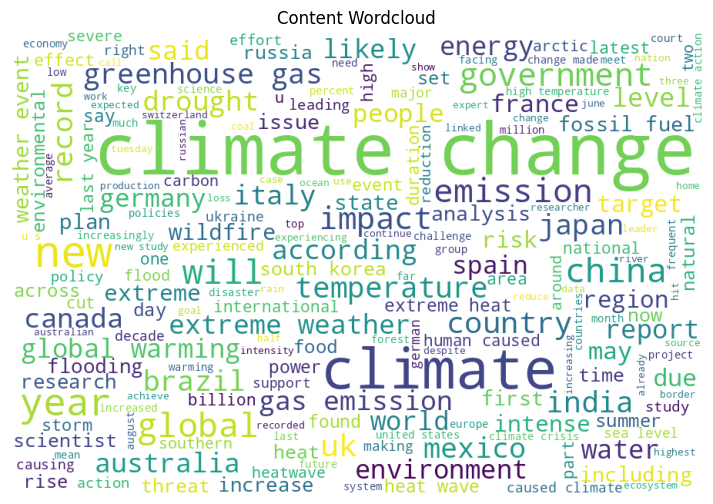

In [ ]:
text=" ".join(df.content)
wordcloud=WordCloud(width=900,height=600,background_color="white").generate(text.lower())
plt.figure(figsize=(9,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Content Wordcloud")
plt.show()

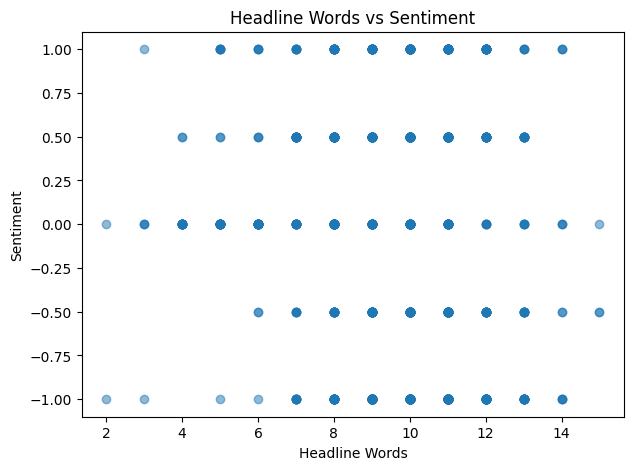

In [ ]:
df["headline_words"]=df.headline.str.split().str.len()
plt.figure(figsize=(7,5))
plt.scatter(df.headline_words,df.sentiment,alpha=0.5)
plt.title("Headline Words vs Sentiment")
plt.xlabel("Headline Words")
plt.ylabel("Sentiment")
plt.show()

# Predicting Headline Sentiment using ml

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

In [11]:
def encode(val):
  if val==-1:
    return 0
  elif val==-0.5:
    return 1
  elif val==0:
    return 2
  elif val==0.5:
    return 3
  else:
    return 4

In [12]:
X=df.headline
y=df.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer=TfidfVectorizer(max_features=950)
X_train_vec=vectorizer.fit_transform(X_train)
X_test_vec=vectorizer.transform(X_test)


lr = LogisticRegression(random_state = 42)
svm = SVC(random_state = 42)
rf = RandomForestClassifier(random_state = 42)

ml_model = VotingClassifier(estimators = [('lr', lr), ('svm', svm), ('rf', rf)])

ml_model.fit(X_train_vec,y_train.apply(encode))
y_pred=ml_model.predict(X_test_vec)
print(classification_report(y_test.apply(encode),y_pred))

              precision    recall  f1-score   support

           0       0.37      0.60      0.46        53
           1       0.40      0.15      0.22        27
           2       0.66      0.48      0.56        52
           3       0.34      0.56      0.43        39
           4       0.33      0.06      0.10        34

    accuracy                           0.41       205
   macro avg       0.42      0.37      0.35       205
weighted avg       0.44      0.41      0.39       205



In [13]:
ml_model2=LogisticRegression()
ml_model2.fit(X_train_vec,y_train.apply(encode))
y_pred=ml_model2.predict(X_test_vec)
print(classification_report(y_test.apply(encode),y_pred))

              precision    recall  f1-score   support

           0       0.37      0.57      0.44        53
           1       0.33      0.19      0.24        27
           2       0.56      0.46      0.51        52
           3       0.33      0.49      0.39        39
           4       0.29      0.06      0.10        34

    accuracy                           0.39       205
   macro avg       0.37      0.35      0.34       205
weighted avg       0.39      0.39      0.37       205



---

# Predicting Sentiment using pretrained models

In [4]:
# del tokenizer


In [43]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification

model_name="google-bert/bert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
train_enc=tokenizer(X_train.tolist(),
                     padding=True,
                     truncation=True,
                     return_tensors="pt")
val_enc=tokenizer(X_test.tolist(),
                   padding=True,
                   truncation=True,
                   return_tensors="pt")

In [16]:
import torch
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
y_train_encoded = y_train.apply(encode).tolist()
y_val_encoded = y_test.apply(encode).tolist()


train_dataset = NewsDataset(train_enc, y_train_encoded)
val_dataset = NewsDataset(val_enc, y_val_encoded)

gpus are really fast...... done a 20+ min job of cpu in 40sec on gpu

In [18]:
!pip install -q evaluate
import evaluate

In [19]:
def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy", trust_remote_code=True)
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

   return {"accuracy": accuracy}

In [36]:
from transformers import TrainingArguments,Trainer
training_args=TrainingArguments(
    output_dir="./results",
    num_train_epochs=15,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    report_to=[],
    evaluation_strategy="epoch"
)
trainer=Trainer(
    model=model.to("cuda"),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.471986,0.390244
2,No log,1.377626,0.448780
3,No log,1.353184,0.424390
4,No log,1.379170,0.443902
5,No log,1.441681,0.468293
6,No log,1.494674,0.453659
7,No log,1.515935,0.487805
8,No log,1.598048,0.482927
9,No log,1.696433,0.453659
10,No log,1.692464,0.443902


TrainOutput(global_step=195, training_loss=0.6751104892828526, metrics={'train_runtime': 75.1287, 'train_samples_per_second': 163.32, 'train_steps_per_second': 2.596, 'total_flos': 163945214470440.0, 'train_loss': 0.6751104892828526, 'epoch': 15.0})

In [39]:
trainer.state.log_history

[{'eval_loss': 1.4719860553741455,
  'eval_accuracy': 0.3902439024390244,
  'eval_runtime': 0.7524,
  'eval_samples_per_second': 272.459,
  'eval_steps_per_second': 9.303,
  'epoch': 1.0,
  'step': 13},
 {'eval_loss': 1.377625584602356,
  'eval_accuracy': 0.44878048780487806,
  'eval_runtime': 0.7497,
  'eval_samples_per_second': 273.443,
  'eval_steps_per_second': 9.337,
  'epoch': 2.0,
  'step': 26},
 {'eval_loss': 1.3531839847564697,
  'eval_accuracy': 0.424390243902439,
  'eval_runtime': 0.7321,
  'eval_samples_per_second': 280.002,
  'eval_steps_per_second': 9.561,
  'epoch': 3.0,
  'step': 39},
 {'eval_loss': 1.3791701793670654,
  'eval_accuracy': 0.44390243902439025,
  'eval_runtime': 0.7459,
  'eval_samples_per_second': 274.819,
  'eval_steps_per_second': 9.384,
  'epoch': 4.0,
  'step': 52},
 {'eval_loss': 1.4416810274124146,
  'eval_accuracy': 0.4682926829268293,
  'eval_runtime': 0.7776,
  'eval_samples_per_second': 263.641,
  'eval_steps_per_second': 9.002,
  'epoch': 5.0,


minimum loss of 1.28 is incurred

In [37]:
model.eval()
outputs=[]
for review in X_test:
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        output=(model(**inputs))
    outputs.append(torch.argmax(output.logits).item())
    # print(f"review: {review}")
    # print(class_names[torch.argmax(outputs.logits).item()],"\n")

In [38]:
print(classification_report(y_test.apply(encode),outputs))

              precision    recall  f1-score   support

           0       0.52      0.57      0.54        53
           1       0.38      0.33      0.35        27
           2       0.71      0.46      0.56        52
           3       0.40      0.67      0.50        39
           4       0.42      0.29      0.34        34

    accuracy                           0.48       205
   macro avg       0.48      0.46      0.46       205
weighted avg       0.51      0.48      0.48       205



---

In [48]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [44]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=4,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query","value","key","dense"],
)

lora_model=get_peft_model(model,lora_config)

In [45]:
lora_model.print_trainable_parameters()

trainable params: 673,541 || all params: 110,159,626 || trainable%: 0.6114


In [46]:
from transformers import TrainingArguments,Trainer
training_args=TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    report_to=[],
    evaluation_strategy="epoch"
    # gradient_accumulation_steps=1
)
trainer=Trainer(
    model=lora_model.to("cuda"),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.585380,0.263415
2,No log,1.577869,0.302439
3,No log,1.573771,0.321951


TrainOutput(global_step=78, training_loss=1.5696705549191206, metrics={'train_runtime': 13.098, 'train_samples_per_second': 187.357, 'train_steps_per_second': 5.955, 'total_flos': 33046890553872.0, 'train_loss': 1.5696705549191206, 'epoch': 3.0})

In [47]:
model.eval()
outputs=[]
for review in X_test:
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        output=(model(**inputs))
    outputs.append(torch.argmax(output.logits).item())

In [48]:
print(classification_report(y_test.apply(encode),outputs))

              precision    recall  f1-score   support

           0       0.29      0.74      0.42        53
           1       0.00      0.00      0.00        27
           2       0.53      0.38      0.44        52
           3       0.21      0.18      0.19        39
           4       0.00      0.00      0.00        34

    accuracy                           0.32       205
   macro avg       0.21      0.26      0.21       205
weighted avg       0.25      0.32      0.26       205

